In [1]:
"""
Takes results path and plots some observable over time, specified at the bottom of the script.
"""
import os
os.environ["JAX_PLATFORMS"] = "cpu"

import matplotlib.pyplot as plt
import json
import dotenv
from pathlib import Path
import pandas as pd
import numpy as np

In [2]:

root_path = '/net/vast-storage/scratch/vast/mcdermott/rphess/modula-v2/'
path = Path(root_path) / "experiment/results/"
sub_folders = ['hardcap_results', 'orthog_results', 'softcap_results', 'spec_normalize_results', 'spec_wd_results', 'specham_results', 'normal_wd_results']

results_concatenated = []
# iterate over all subfolders and open all json files in them
for sub_folder in sub_folders:
    sub_folder_path = path / sub_folder
    for json_file in sub_folder_path.glob('*.json'):
        with open(json_file, 'r') as f:
            data = json.load(f)
            # add the data to the results list
            results = data['results']
            technique = data['parameters']['project']['default']
            lr = data['parameters']['lr']
            wmax = data['parameters']['w_max']
            best_train_loss = min(results['losses'])
            best_val_loss = min(results['val_losses'])
            best_train_acc = max(results['train_accuracies'])
            best_val_acc = max(results['accuracies'])
            final_train_loss = results['losses'][-1]
            final_val_loss = results['val_losses'][-1]
            final_train_acc = results['train_accuracies'][-1]
            final_val_acc = results['accuracies'][-1]
            spec_wd = data['parameters']['spectral_wd']
            wd = data['parameters']['wd']
            row = {
                'technique': technique,
                'lr': lr,
                'w_max': wmax,
                'best_train_loss': best_train_loss,
                'best_val_loss': best_val_loss,
                'best_train_acc': best_train_acc,
                'best_val_acc': best_val_acc,
                'final_train_loss': final_train_loss,
                'final_val_loss': final_val_loss,
                'final_train_acc': final_train_acc,
                'final_val_acc': final_val_acc,
                'spectral_wd': spec_wd,
                'wd': wd,
            }
            results_concatenated.append(row)
# create a dataframe from the results
results_df = pd.DataFrame(results_concatenated)

In [3]:
results_df

,technique,lr,w_max,best_train_loss,best_val_loss,best_train_acc,best_val_acc,final_train_loss,final_val_loss,final_train_acc,final_val_acc,spectral_wd,wd
0,hard_cap,0.010000,8,2.302001,2.302455,0.173828,0.173242,2.302585,2.302585,0.089844,0.103809,0.0,0.000000
1,hard_cap,0.010000,4,2.301896,2.302429,0.167969,0.173535,2.302585,2.302585,0.089844,0.103613,0.0,0.000000
2,hard_cap,0.010000,7,2.301990,2.302452,0.167969,0.172656,2.302585,2.302585,0.091797,0.104199,0.0,0.000000
3,hard_cap,0.010000,9,2.302007,2.302456,0.169922,0.176172,2.302585,2.302585,0.091797,0.104785,0.0,0.000000
4,hard_cap,0.010000,6,2.301977,2.302449,0.173828,0.186035,2.302585,2.302585,0.091797,0.103906,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
923,none,6.309573,0,0.598449,1.261714,0.814453,0.561230,0.598449,1.262724,0.812500,0.561230,0.0,0.046416
924,none,6.309573,0,0.856144,1.190190,0.748047,0.577832,0.856144,1.190190,0.736328,0.577832,0.0,0.100000
925,none,6.309573,0,1.235084,1.335322,0.619141,0.549219,1.235084,1.335322,0.593750,0.549219,0.0,0.215443
926,none,6.309573,0,1.744547,1.755071,0.462891,0.441602,1.744547,1.755071,0.431641,0.441602,0.0,0.464159


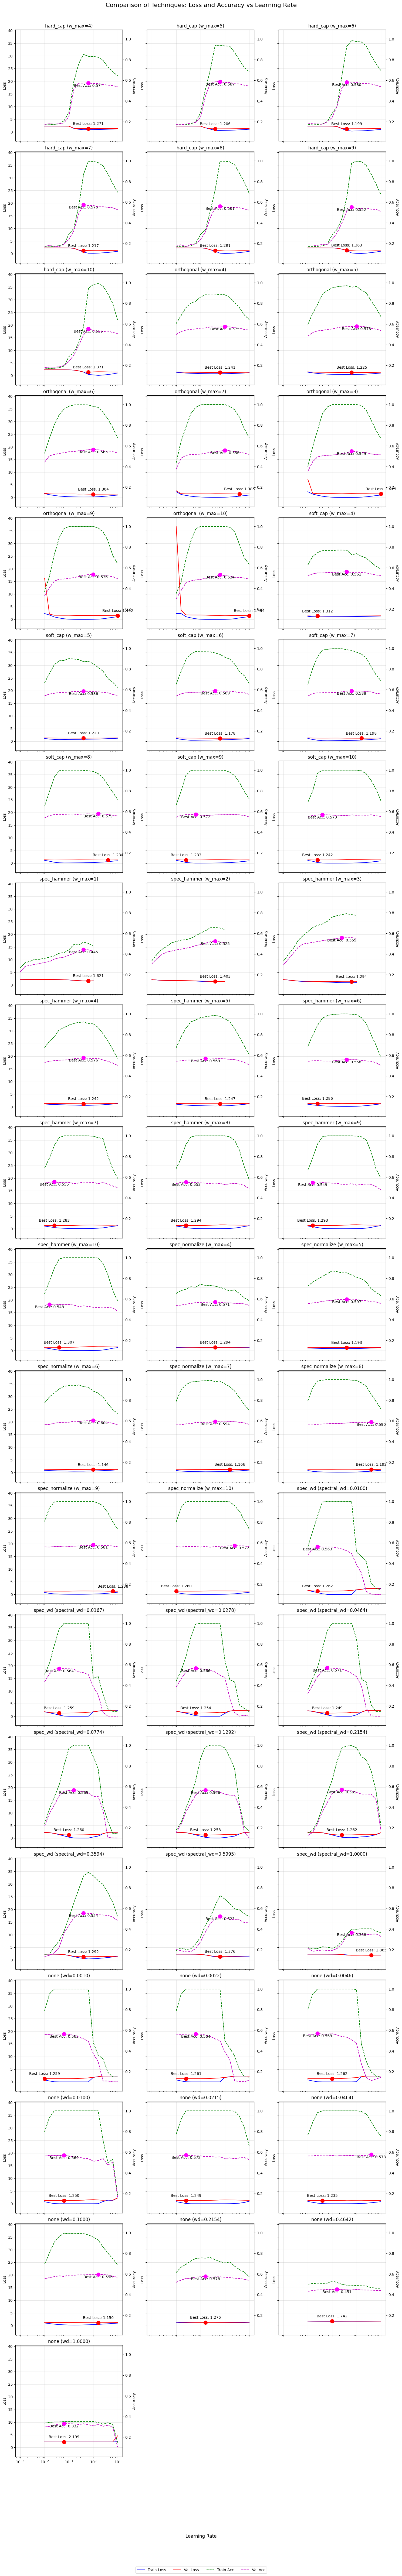

In [5]:
# Create a copy of the dataframe for plotting
plot_df = results_df.copy()

# For 'spec_wd' technique, group by 'spectral_wd' instead of 'w_max'
spec_wd_mask = plot_df['technique'] == 'spec_wd'
none_mask = plot_df['technique'] == 'none'
other_mask = ~(spec_wd_mask | none_mask)

# Group the dataframes separately
grouped_other = plot_df[other_mask].groupby(['technique', 'w_max'])
grouped_spec_wd = plot_df[spec_wd_mask].groupby(['technique', 'spectral_wd'])
grouped_none = plot_df[none_mask].groupby(['technique', 'wd'])  # Group 'none' by 'spectral_wd' which acts as 'wd'

# Get unique combinations for all groups
technique_wmax_pairs = list(grouped_other.groups.keys())
technique_spectral_wd_pairs = list(grouped_spec_wd.groups.keys())
technique_none_wd_pairs = list(grouped_none.groups.keys())

# Combine them for plotting
all_plot_pairs = technique_wmax_pairs + technique_spectral_wd_pairs + technique_none_wd_pairs

# Determine the number of plots needed and create a grid
num_plots = len(all_plot_pairs)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols  # Ceiling division

# Create the figure with appropriate size and share both x and y axes
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True, sharey=True)
axs = axs.flatten()

# Find global min and max values for losses and accuracies
min_loss = min(results_df['best_train_loss'].min(), results_df['best_val_loss'].min())
max_loss = max(results_df['best_train_loss'].max(), results_df['best_val_loss'].max())
min_acc = min(results_df['best_train_acc'].min(), results_df['best_val_acc'].min())
max_acc = max(results_df['best_train_acc'].max(), results_df['best_val_acc'].max())

# Add some padding to the ranges
loss_range = max_loss - min_loss
acc_range = max_acc - min_acc
loss_padding = loss_range * 0.1
acc_padding = acc_range * 0.1
loss_ylim = (min_loss - loss_padding, max_loss + loss_padding)
acc_ylim = (min_acc - acc_padding, max_acc + acc_padding)

# Loop through each pair
for i, pair in enumerate(all_plot_pairs):
    if i >= len(axs):  # Safety check in case there are more pairs than axes
        break
    
    technique = pair[0]
    
    # Filter the dataframe based on the technique
    if technique == 'spec_wd':
        spectral_wd = pair[1]
        subset_df = results_df[(results_df['technique'] == technique) & 
                               (results_df['spectral_wd'] == spectral_wd)]
        title = f'{technique} (spectral_wd={spectral_wd:.4f})'
    elif technique == 'none':
        wd = pair[1]
        subset_df = results_df[(results_df['technique'] == technique) & 
                              (results_df['wd'] == wd)]
        title = f'{technique} (wd={wd:.4f})'
    else:
        wmax = pair[1]
        subset_df = results_df[(results_df['technique'] == technique) & 
                               (results_df['w_max'] == wmax)]
        title = f'{technique} (w_max={wmax})'
        
    # Create a twin axis for accuracies
    ax2 = axs[i].twinx()
    
    # Sort by learning rate for better line plotting
    subset_df = subset_df.sort_values('lr')
    
    # plot the best train and val loss as a function of the learning rate on left axis
    loss_lines1, = axs[i].plot(subset_df['lr'], subset_df['best_train_loss'], 'b-', label='Train Loss')
    loss_lines2, = axs[i].plot(subset_df['lr'], subset_df['best_val_loss'], 'r-', label='Val Loss')
    
    # plot the best train and val accuracy as a function of the learning rate on right axis
    acc_lines1, = ax2.plot(subset_df['lr'], subset_df['best_train_acc'], 'g--', label='Train Acc')
    acc_lines2, = ax2.plot(subset_df['lr'], subset_df['best_val_acc'], 'm--', label='Val Acc')
    
    # Find the point with the best validation loss and mark it
    if not subset_df.empty:
        best_idx = subset_df['best_val_loss'].idxmin()
        best_lr = subset_df.loc[best_idx, 'lr']
        best_val_loss = subset_df.loc[best_idx, 'best_val_loss']
        axs[i].scatter(best_lr, best_val_loss, color='red', s=100, zorder=5)
        axs[i].annotate(f'Best Loss: {best_val_loss:.3f}', 
                       (best_lr, best_val_loss),
                       xytext=(0, 10), 
                       textcoords='offset points',
                       ha='center')
        
        # Find the point with the best validation accuracy and mark it
        best_acc_idx = subset_df['best_val_acc'].idxmax()
        best_acc_lr = subset_df.loc[best_acc_idx, 'lr']
        best_val_acc = subset_df.loc[best_acc_idx, 'best_val_acc']
        ax2.scatter(best_acc_lr, best_val_acc, color='magenta', s=100, zorder=5)
        ax2.annotate(f'Best Acc: {best_val_acc:.3f}', 
                    (best_acc_lr, best_val_acc),
                    xytext=(0, -10), 
                    textcoords='offset points',
                    ha='center')
    
    axs[i].set_title(title)
    axs[i].set_xscale('log')
    axs[i].grid(True, alpha=0.3)
    
    # Set labels for the axes
    axs[i].set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    
    # Set the same y-limits for all plots
    axs[i].set_ylim(loss_ylim)
    ax2.set_ylim(acc_ylim)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

# Common x-axis label
fig.text(0.5, 0.04, 'Learning Rate', ha='center', fontsize=12)

# Title for the entire figure
fig.suptitle('Comparison of Techniques: Loss and Accuracy vs Learning Rate', fontsize=16, y=0.98)

# Create a unified legend
lines = [loss_lines1, loss_lines2, acc_lines1, acc_lines2]
labels = ['Train Loss', 'Val Loss', 'Train Acc', 'Val Acc']
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.03), ncol=4)

plt.tight_layout()
plt.subplots_adjust(top=0.97, bottom=0.07)  # Increase the top margin to make room for the title
plt.show()


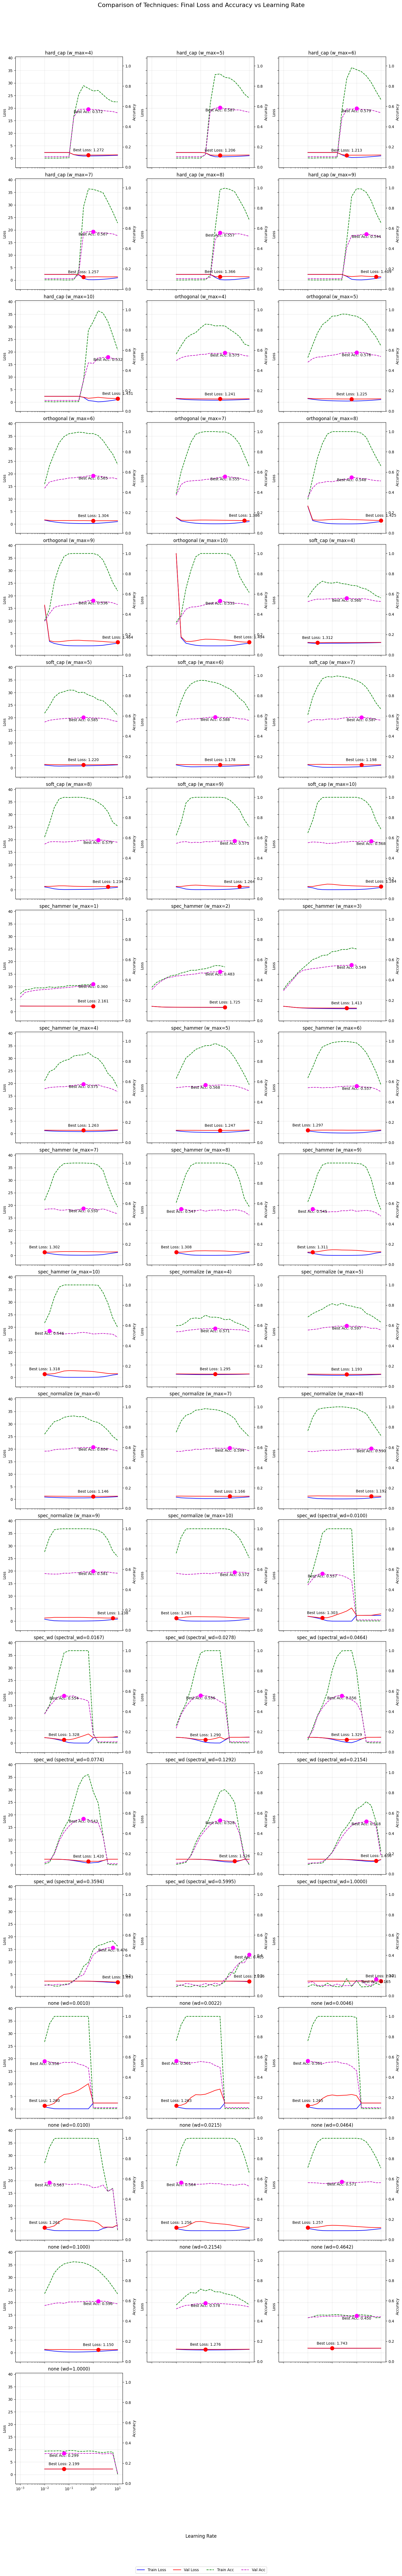

In [6]:
# Create a copy of the dataframe for plotting
plot_df = results_df.copy()

# For 'spec_wd' technique, group by 'spectral_wd' instead of 'w_max'
spec_wd_mask = plot_df['technique'] == 'spec_wd'
none_mask = plot_df['technique'] == 'none'
other_mask = ~(spec_wd_mask | none_mask)

# Group the dataframes separately
grouped_other = plot_df[other_mask].groupby(['technique', 'w_max'])
grouped_spec_wd = plot_df[spec_wd_mask].groupby(['technique', 'spectral_wd'])
grouped_none = plot_df[none_mask].groupby(['technique', 'wd'])  # Group 'none' by 'spectral_wd' which acts as 'wd'

# Get unique combinations for all groups
technique_wmax_pairs = list(grouped_other.groups.keys())
technique_spectral_wd_pairs = list(grouped_spec_wd.groups.keys())
technique_none_wd_pairs = list(grouped_none.groups.keys())

# Combine them for plotting
all_plot_pairs = technique_wmax_pairs + technique_spectral_wd_pairs + technique_none_wd_pairs

# Determine the number of plots needed and create a grid
num_plots = len(all_plot_pairs)
num_cols = 3
num_rows = (num_plots + num_cols - 1) // num_cols  # Ceiling division

# Create the figure with appropriate size and share both x and y axes
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows), sharex=True, sharey=True)
axs = axs.flatten()

# Find global min and max values for losses and accuracies
min_loss = min(results_df['final_train_loss'].min(), results_df['final_val_loss'].min())
max_loss = max(results_df['final_train_loss'].max(), results_df['final_val_loss'].max())
min_acc = min(results_df['final_train_acc'].min(), results_df['final_val_acc'].min())
max_acc = max(results_df['final_train_acc'].max(), results_df['final_val_acc'].max())

# Add some padding to the ranges
loss_range = max_loss - min_loss
acc_range = max_acc - min_acc
loss_padding = loss_range * 0.1
acc_padding = acc_range * 0.1
loss_ylim = (min_loss - loss_padding, max_loss + loss_padding)
acc_ylim = (min_acc - acc_padding, max_acc + acc_padding)

# Loop through each pair
for i, pair in enumerate(all_plot_pairs):
    if i >= len(axs):  # Safety check in case there are more pairs than axes
        break
    
    technique = pair[0]
    
    # Filter the dataframe based on the technique
    if technique == 'spec_wd':
        spectral_wd = pair[1]
        subset_df = results_df[(results_df['technique'] == technique) & 
                               (results_df['spectral_wd'] == spectral_wd)]
        title = f'{technique} (spectral_wd={spectral_wd:.4f})'
    elif technique == 'none':
        wd = pair[1]
        subset_df = results_df[(results_df['technique'] == technique) & 
                              (results_df['wd'] == wd)]
        title = f'{technique} (wd={wd:.4f})'
    else:
        wmax = pair[1]
        subset_df = results_df[(results_df['technique'] == technique) & 
                               (results_df['w_max'] == wmax)]
        title = f'{technique} (w_max={wmax})'
        
    # Create a twin axis for accuracies
    ax2 = axs[i].twinx()
    
    # Sort by learning rate for better line plotting
    subset_df = subset_df.sort_values('lr')
    
    # plot the best train and val loss as a function of the learning rate on left axis
    loss_lines1, = axs[i].plot(subset_df['lr'], subset_df['final_train_loss'], 'b-', label='Train Loss')
    loss_lines2, = axs[i].plot(subset_df['lr'], subset_df['final_val_loss'], 'r-', label='Val Loss')
    
    # plot the best train and val accuracy as a function of the learning rate on right axis
    acc_lines1, = ax2.plot(subset_df['lr'], subset_df['final_train_acc'], 'g--', label='Train Acc')
    acc_lines2, = ax2.plot(subset_df['lr'], subset_df['final_val_acc'], 'm--', label='Val Acc')
    
    # Find the point with the best validation loss and mark it
    if not subset_df.empty:
        best_idx = subset_df['final_val_loss'].idxmin()
        best_lr = subset_df.loc[best_idx, 'lr']
        best_val_loss = subset_df.loc[best_idx, 'final_val_loss']
        axs[i].scatter(best_lr, best_val_loss, color='red', s=100, zorder=5)
        axs[i].annotate(f'Best Loss: {best_val_loss:.3f}', 
                       (best_lr, best_val_loss),
                       xytext=(0, 10), 
                       textcoords='offset points',
                       ha='center')
        
        # Find the point with the best validation accuracy and mark it
        best_acc_idx = subset_df['final_val_acc'].idxmax()
        best_acc_lr = subset_df.loc[best_acc_idx, 'lr']
        best_val_acc = subset_df.loc[best_acc_idx, 'final_val_acc']
        ax2.scatter(best_acc_lr, best_val_acc, color='magenta', s=100, zorder=5)
        ax2.annotate(f'Best Acc: {best_val_acc:.3f}', 
                    (best_acc_lr, best_val_acc),
                    xytext=(0, -10), 
                    textcoords='offset points',
                    ha='center')
    
    axs[i].set_title(title)
    axs[i].set_xscale('log')
    axs[i].grid(True, alpha=0.3)
    
    # Set labels for the axes
    axs[i].set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    
    # Set the same y-limits for all plots
    axs[i].set_ylim(loss_ylim)
    ax2.set_ylim(acc_ylim)

# Hide any unused subplots
for j in range(i + 1, len(axs)):
    axs[j].set_visible(False)

# Common x-axis label
fig.text(0.5, 0.04, 'Learning Rate', ha='center', fontsize=12)

# Title for the entire figure
fig.suptitle('Comparison of Techniques: Final Loss and Accuracy vs Learning Rate', fontsize=16, y=0.98)

# Create a unified legend
lines = [loss_lines1, loss_lines2, acc_lines1, acc_lines2]
labels = ['Train Loss', 'Val Loss', 'Train Acc', 'Val Acc']
fig.legend(lines, labels, loc='upper center', bbox_to_anchor=(0.5, 0.03), ncol=4)

plt.tight_layout()
plt.subplots_adjust(top=0.96, bottom=0.06)  # Increase the top margin to make room for the title
plt.show()


In [7]:
#for each w_max, technique pair, print the learning rate that results in the best overall validation accuracy
# and print the learning rate that results in the best final validation accuracy
# Group by the appropriate parameters for each technique
print("Best Learning Rates for Different Techniques and Parameters:")

# For 'none' technique, group by wd
none_df = results_df[results_df['technique'] == 'none']
for wd, group in none_df.groupby('wd'):
    best_overall_idx = group['best_val_acc'].idxmax()
    best_overall_lr = group.loc[best_overall_idx, 'lr']
    best_overall_val_acc = group.loc[best_overall_idx, 'best_val_acc']
    
    best_final_idx = group['final_val_acc'].idxmax()
    best_final_lr = group.loc[best_final_idx, 'lr']
    best_final_val_acc = group.loc[best_final_idx, 'final_val_acc']
    
    print(f'Technique: none, wd: {wd:.6f}')
    print(f'  Best Overall LR: {best_overall_lr}, Best Overall Val Acc: {best_overall_val_acc:.6f}')
    print(f'  Best Final LR: {best_final_lr}, Best Final Val Acc: {best_final_val_acc:.6f}')
    print('---')

# For 'spec_wd' technique, group by spectral_wd
spec_wd_df = results_df[results_df['technique'] == 'spec_wd']
for spectral_wd, group in spec_wd_df.groupby('spectral_wd'):
    best_overall_idx = group['best_val_acc'].idxmax()
    best_overall_lr = group.loc[best_overall_idx, 'lr']
    best_overall_val_acc = group.loc[best_overall_idx, 'best_val_acc']
    
    best_final_idx = group['final_val_acc'].idxmax()
    best_final_lr = group.loc[best_final_idx, 'lr']
    best_final_val_acc = group.loc[best_final_idx, 'final_val_acc']
    
    print(f'Technique: spec_wd, spectral_wd: {spectral_wd:.6f}')
    print(f'  Best Overall LR: {best_overall_lr}, Best Overall Val Acc: {best_overall_val_acc:.6f}')
    print(f'  Best Final LR: {best_final_lr}, Best Final Val Acc: {best_final_val_acc:.6f}')
    print('---')

# For all other techniques, group by w_max
other_df = results_df[(results_df['technique'] != 'none') & (results_df['technique'] != 'spec_wd')]
for (technique, wmax), group in other_df.groupby(['technique', 'w_max']):
    best_overall_idx = group['best_val_acc'].idxmax()
    best_overall_lr = group.loc[best_overall_idx, 'lr']
    best_overall_val_acc = group.loc[best_overall_idx, 'best_val_acc']
    
    best_final_idx = group['final_val_acc'].idxmax()
    best_final_lr = group.loc[best_final_idx, 'lr']
    best_final_val_acc = group.loc[best_final_idx, 'final_val_acc']
    
    print(f'Technique: {technique}, w_max: {wmax}')
    print(f'  Best Overall LR: {best_overall_lr}, Best Overall Val Acc: {best_overall_val_acc:.6f}')
    print(f'  Best Final LR: {best_final_lr}, Best Final Val Acc: {best_final_val_acc:.6f}')
    print('---')

Best Learning Rates for Different Techniques and Parameters:
Technique: none, wd: 0.001000
  Best Overall LR: 0.06309573444801933, Best Overall Val Acc: 0.565430
  Best Final LR: 0.01, Best Final Val Acc: 0.558203
---
Technique: none, wd: 0.002154
  Best Overall LR: 0.06309573444801933, Best Overall Val Acc: 0.563672
  Best Final LR: 0.01, Best Final Val Acc: 0.561328
---
Technique: none, wd: 0.004642
  Best Overall LR: 0.025118864315095794, Best Overall Val Acc: 0.568652
  Best Final LR: 0.01, Best Final Val Acc: 0.561328
---
Technique: none, wd: 0.010000
  Best Overall LR: 0.06309573444801933, Best Overall Val Acc: 0.568555
  Best Final LR: 0.015848931924611134, Best Final Val Acc: 0.562598
---
Technique: none, wd: 0.021544
  Best Overall LR: 0.025118864315095794, Best Overall Val Acc: 0.572070
  Best Final LR: 0.015848931924611134, Best Final Val Acc: 0.564453
---
Technique: none, wd: 0.046416
  Best Overall LR: 3.981071705534973, Best Overall Val Acc: 0.578027
  Best Final LR: 0.25

In [8]:
# print unique learning rate values
unique_lrs = results_df['lr'].unique()
unique_lrs.sort()
unique_lrs

array([1.00000000e-03, 1.58489319e-03, 2.51188643e-03, 3.98107171e-03,
       6.30957344e-03, 1.00000000e-02, 1.58489319e-02, 1.58489319e-02,
       2.51188643e-02, 2.51188643e-02, 3.98107171e-02, 6.30957344e-02,
       1.00000000e-01, 1.58489319e-01, 2.51188643e-01, 2.51188643e-01,
       3.98107171e-01, 6.30957344e-01, 6.30957344e-01, 1.00000000e+00,
       1.58489319e+00, 2.51188643e+00, 3.98107171e+00, 6.30957344e+00,
       1.00000000e+01])

In [9]:
(0.06309573444801933 + 0.25118864315095807) / 2

0.1571421887994887